In [1]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve
import warnings
from sklearn.preprocessing import LabelEncoder
import gc
import os
import time
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体，解决乱码问题
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
sns.set(font='SimHei', font_scale=0.8)
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../data/train.csv')
label = pd.read_csv('../data/train_label.csv')
test = pd.read_csv('../data/test.csv')
sub = pd.read_csv('../data/submission.csv')

In [3]:
df_source = train.merge(label,on='ID',how='left')


test['label'] = -1
train = train.merge(label,on='ID',how='left')
data = pd.concat([train, test])


In [4]:


#提取时间特征

def get_time_fe(df):
    df['day'] = df.date.apply(lambda x:int(x[8:10]))
    df['hour'] = df.date.apply(lambda x:int(x[11:13]))
    return df





#对时间分箱
def getSeg(x):
    if x >=0 and x<= 3:
        return 1
    elif x>=4 and x<=12:
        return 2
    elif x>=13 and x<=18:
        return 3
    elif x>=19 and x<=23:
        return 1




#count统计特征
cross_feature = []
def get_cross_fe(df):
    first_feature = [ 'B2', 'B3']
    second_feature = ['C1','C2','C3','D1','A1','A2','A3']
    for feat_1 in first_feature:
        for feat_2 in second_feature:
            col_name = "cross_" + feat_1 + "_and_" + feat_2
            cross_feature.append(col_name)
            df[col_name] = df[feat_1].astype(str).values + '_' + df[feat_2].astype(str).values
    return df



#获取nunique特征
def get_nunique_1_fe(df):
    adid_nuq = [ 'hour','E1','E14','B2','B3']
    for feat in adid_nuq:
        gp1 = df.groupby('A2')[feat].nunique().reset_index().rename(columns={feat: "A2_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['A2'].nunique().reset_index().rename(columns={'A2': "%s_A2_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['A2'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df
def get_nunique_2_fe(df):
    adid_nuq = [ 'E1','E14']
    for feat in adid_nuq:
        gp1 = df.groupby('hour')[feat].nunique().reset_index().rename(columns={feat: "hour_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['hour'].nunique().reset_index().rename(columns={'hour': "%s_hour_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['hour'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df

# def get_nunique_3_fe(df):
#     adid_nuq = ['B2','B3']
#     for feat in adid_nuq:
#         gp1 = df.groupby('A3')[feat].nunique().reset_index().rename(columns={feat: "A3_%s_nuq_num" % feat})
#         gp2 = df.groupby(feat)['A3'].nunique().reset_index().rename(columns={'A3': "%s_A3_nuq_num" % feat})
#         df = pd.merge(df, gp1, how='left', on=['A3'])
#         df = pd.merge(df, gp2, how='left', on=[feat])
#     return df

def get_nunique_4_fe(df):
    adid_nuq = [ 'B2','B3']
    for feat in adid_nuq:
        gp1 = df.groupby('A1')[feat].nunique().reset_index().rename(columns={feat: "A1_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['A1'].nunique().reset_index().rename(columns={'A1': "%s_A1_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['A1'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df




data = get_time_fe(data)
# data['hour_seg'] = data['hour'].apply(lambda x: getSeg(x))
data = get_cross_fe(data)
data = get_nunique_1_fe(data)
data = get_nunique_2_fe(data)
# data = get_nunique_3_fe(data)
# data = get_nunique_4_fe(data)



len(cross_feature)




#labelencoder()
cate_feature = ['A1','A2','A3','B1','B2','B3','C1','C2','C3','E2','E3','E5','E7','E9','E10','E13','E16','E17','E19','E21','E22']
# cross_feature = cross_feature[:15]
cate_features = cate_feature+cross_feature
for item in cate_features:
    data[item] = LabelEncoder().fit_transform(data[item])


# In[14]:


def feature_count(data, features=[]):
    new_feature = 'count'
    for i in features:
        new_feature += '_' + i
    try:
        del data[new_feature]
    except:
        pass
    temp = data.groupby(features).size().reset_index().rename(columns={0: new_feature})
    data = data.merge(temp, 'left', on=features)
    return data

for i in cross_feature:
    n = data[i].nunique()
    if n > 5:
        data = feature_count(data, [i])
    else:
        print(i, ':', n)


# In[15]:


#ratio：类别偏好的ratio比例特征
label_feature =[ 'A2', 'A3','hour']
data_temp = data[label_feature]
df_feature = pd.DataFrame()
data_temp['cnt'] = 1
print('Begin ratio clcik...')
col_type = label_feature.copy()
n = len(col_type)
for i in range(n):
    col_name = "ratio_click_of_" + col_type[i]
    df_feature[col_name] = (
                    data_temp[col_type[i]].map(data_temp[col_type[i]].value_counts()) / len(data) * 100).astype(int)            
data = pd.concat([data, df_feature], axis=1)
print('The end')




train_df = data[data['label'] != -1]
test_df = data[data['label'] == -1]







# # 删除不需要的字段



from sklearn.model_selection import train_test_split, StratifiedKFold





## get train feature
del_feature = ['ID','day','date','label','D2']+cross_feature
features = [i for i in train_df.columns if i not in del_feature]




train_x = train_df[features]
train_y = train_df['label'].values
test_x = test_df[features]





# 设置随机种子，保证结果可复现
np.random.seed(42)

# 假设train_x（DataFrame或数组）和train_y（Series或数组）是已有的训练数据
# 请确保在实际使用时已经正确加载了这两个变量

# 确保train_y是一维数组
if isinstance(train_y, pd.Series):
    train_y = train_y.values

# 获取特征数量和特征名称
if isinstance(train_x, pd.DataFrame):
    n_features = train_x.shape[1]
    feature_names = train_x.columns.tolist()
else:
    n_features = train_x.shape[1]
    feature_names = [f'特征{i+1}' for i in range(n_features)]




Begin ratio clcik...
The end


In [5]:
test_x.shape

(40000, 71)

In [6]:
# 十折交叉验证配置
def get_lgb_params():
    """单组LightGBM参数配置"""
    return {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'seed': 42,
        'n_jobs': -1
    }

# 模型评估指标
def calculate_metrics(y_true, y_pred_proba):
    auc = roc_auc_score(y_true, y_pred_proba)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    
    thresholds = np.arange(0.1, 1.0, 0.1)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1_scores.append(f1_score(y_true, y_pred))
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
    
    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_threshold = thresholds[best_f1_idx]
    
    return {
        'auc': auc, 'ks': ks, 'best_f1': best_f1,
        'best_threshold': best_threshold, 'thresholds': thresholds,
        'f1_scores': f1_scores, 'precision_scores': precision_scores,
        'recall_scores': recall_scores, 'fpr': fpr, 'tpr': tpr
    }

# 指标可视化
def plot_metrics(metrics, figsize=(15, 10)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('模型评估指标', fontsize=16)
    
    # 关键指标
    ax1 = axes[0, 0]
    metrics_text = (f"AUC: {metrics['auc']:.4f}\nKS: {metrics['ks']:.4f}\n"
                   f"最佳F1: {metrics['best_f1']:.4f}\n最佳阈值: {metrics['best_threshold']:.2f}")
    ax1.text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center')
    ax1.set_title('关键指标值')
    ax1.axis('off')
    
    # ROC曲线
    ax2 = axes[0, 1]
    ax2.plot(metrics['fpr'], metrics['tpr'], label=f'ROC曲线 (AUC = {metrics["auc"]:.4f})')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('假正例率 (FPR)')
    ax2.set_ylabel('真正例率 (TPR)')
    ax2.set_title('ROC曲线')
    ax2.legend()
    
    # KS曲线
    ax3 = axes[1, 0]
    ax3.plot(metrics['fpr'], label='FPR')
    ax3.plot(metrics['tpr'], label='TPR')
    ax3.plot(metrics['tpr'] - metrics['fpr'], label=f'KS ({metrics["ks"]:.4f})')
    ax3.set_xlabel('阈值')
    ax3.set_ylabel('比例')
    ax3.set_title('KS曲线')
    ax3.legend()
    
    # 阈值指标
    ax4 = axes[1, 1]
    ax4.plot(metrics['thresholds'], metrics['f1_scores'], label='F1分数')
    ax4.plot(metrics['thresholds'], metrics['precision_scores'], label='精确率')
    ax4.plot(metrics['thresholds'], metrics['recall_scores'], label='召回率')
    ax4.axvline(x=metrics['best_threshold'], color='r', linestyle='--', 
                label=f'最佳阈值: {metrics["best_threshold"]:.2f}')
    ax4.set_xlabel('阈值')
    ax4.set_ylabel('分数')
    ax4.set_title('不同阈值下的分类指标')
    ax4.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 特征重要性可视化
def plot_feature_importance(importance, feature_names, figsize=(12, 8), top_n=50):
    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=figsize)
    sns.barplot(x='importance', y='feature', data=feat_imp)
    plt.title(f'特征重要性（前{top_n}）', fontsize=15)
    plt.xlabel('重要性 (Gain)', fontsize=12)
    plt.ylabel('特征', fontsize=12)
    plt.tight_layout()
    plt.show()

开始十折交叉验证训练...

第 1 折训练...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.769524	valid's auc: 0.724278
[200]	train's auc: 0.803054	valid's auc: 0.725998
Early stopping, best iteration is:
[229]	train's auc: 0.811411	valid's auc: 0.727525
第 1 折 - AUC: 0.7275, KS: 0.3377, 最佳F1: 0.4072

第 2 折训练...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.768259	valid's auc: 0.73131
[200]	train's auc: 0.802108	valid's auc: 0.732224
Early stopping, best iteration is:
[162]	train's auc: 0.790047	valid's auc: 0.732786
第 2 折 - AUC: 0.7328, KS: 0.3475, 最佳F1: 0.4159

第 3 折训练...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.768609	valid's auc: 0.721217
Early stopping, best iteration is:
[143]	train's auc: 0.784419	valid's auc: 0.723654
第 3 折 - AUC: 0.7237, KS: 0.3333, 最佳F1: 0.3956

第 4 折训练...
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.769762	valid's auc: 0.722444
[2

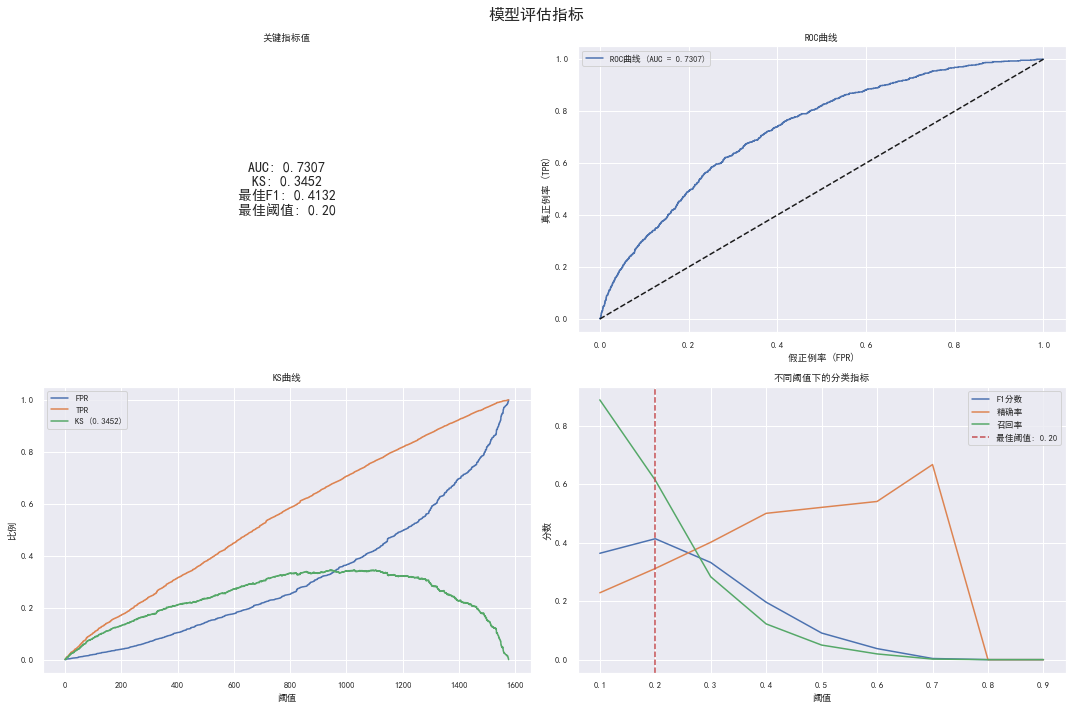


十折交叉验证结果:
平均AUC: 0.7266 ± 0.0050
平均KS: 0.3410 ± 0.0081
平均最佳F1: 0.4056 ± 0.0060


In [7]:

# 十折交叉验证训练
print("开始十折交叉验证训练...")
params = get_lgb_params()
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train_x))
test_preds = np.zeros(len(test_x))
feature_importance = np.zeros(len(features))
auc_scores = []
ks_scores = []
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    print(f"\n第 {fold+1} 折训练...")
    X_train, X_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
    y_train, y_val = train_y[train_idx], train_y[val_idx]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    # 预测与评估
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    oof_preds[val_idx] = val_pred
    test_preds += model.predict(test_x, num_iteration=model.best_iteration) / kf.n_splits
    
    # 特征重要性累加
    feature_importance += model.feature_importance(importance_type='gain') / kf.n_splits
    
    # 计算指标
    metrics = calculate_metrics(y_val, val_pred)
    auc_scores.append(metrics['auc'])
    ks_scores.append(metrics['ks'])
    f1_scores.append(metrics['best_f1'])
    
    print(f"第 {fold+1} 折 - AUC: {metrics['auc']:.4f}, KS: {metrics['ks']:.4f}, 最佳F1: {metrics['best_f1']:.4f}")
    
    # 最后一折绘制详细指标
    if fold == kf.n_splits - 1:
        print("\n最后一折指标可视化:")
        plot_metrics(metrics)

# 整体评估
print("\n十折交叉验证结果:")
print(f"平均AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"平均KS: {np.mean(ks_scores):.4f} ± {np.std(ks_scores):.4f}")
print(f"平均最佳F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

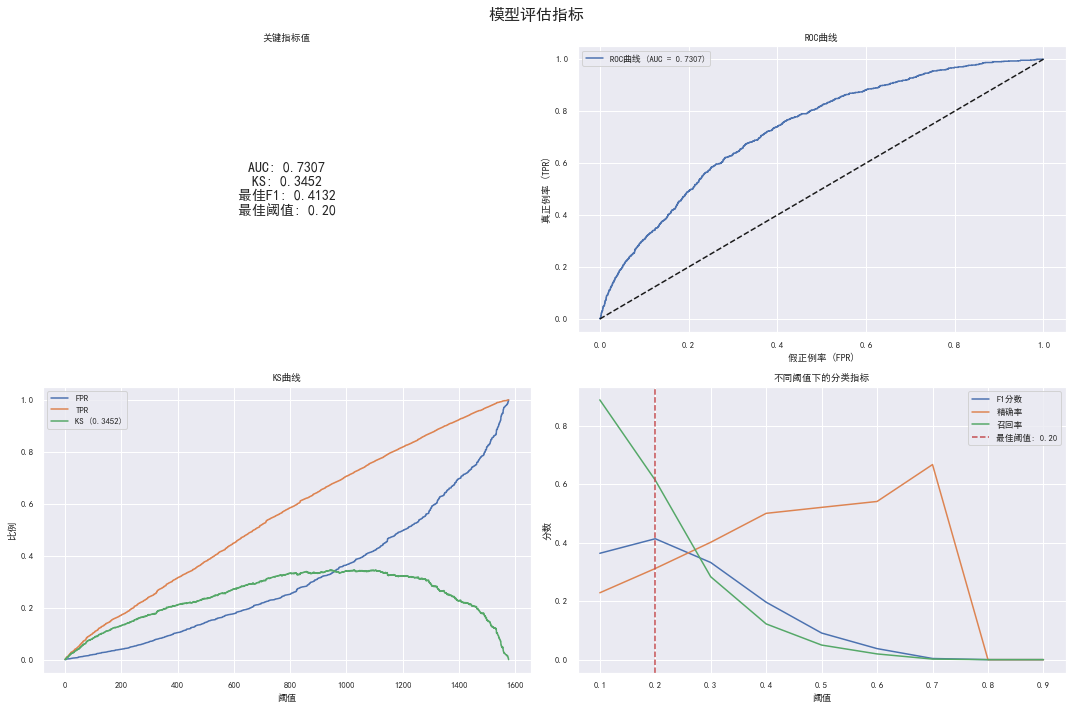

In [8]:
# 绘制评估指标可视化
plot_metrics(metrics)

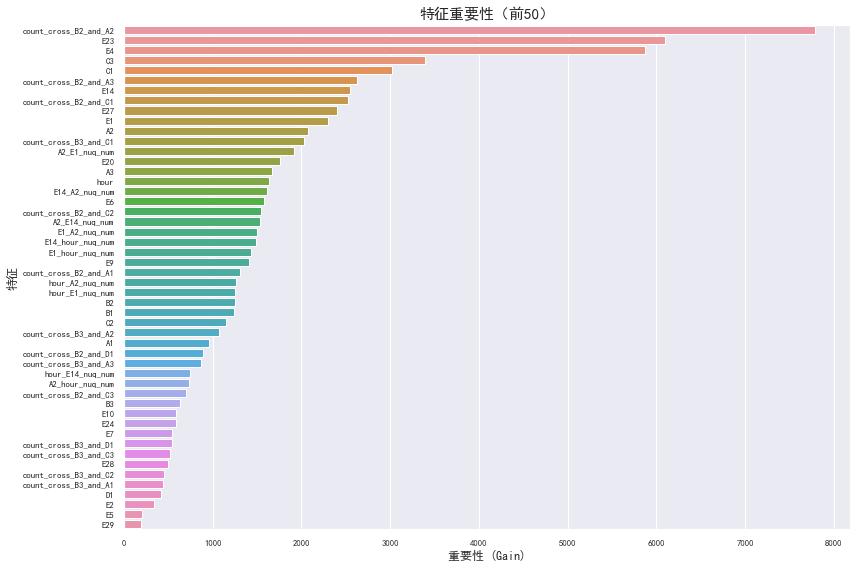

In [9]:
# 特征重要性可视化
plot_feature_importance(feature_importance, features)

In [10]:
# 保存模型和预测结果
print("\n保存模型和预测结果...")
# 保存最后一折模型作为代表
with open('./models/lgb_10fold_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 生成提交文件
sub['pred'] = test_preds
sub.to_csv('submission_10fold.csv', index=False)
print("提交文件已保存为 submission_10fold.csv")


保存模型和预测结果...
提交文件已保存为 submission_10fold.csv


In [11]:
# 加载模型并对测试集进行预测
def load_model_and_predict(model_path, test_data):
    """
    加载保存的模型并对测试集进行预测
    
    参数:
    model_path: 模型保存路径
    test_data: 测试数据集（包含特征列）
    features: 特征列名列表
    
    返回:
    测试集预测概率
    """
    # 加载模型
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        print(f"模型加载成功: {model_path}")
    except Exception as e:
        print(f"模型加载失败: {str(e)}")
        return None

    # 进行预测
    test_pred = model.predict(test_x, num_iteration=model.best_iteration)
    print(f"测试集预测完成，共 {len(test_pred)} 条数据")
    
    return test_pred

In [12]:
# 加载模型并预测
model_path = './models/lgb_10fold_model.pkl'  # 模型保存路径
test_predictions = load_model_and_predict(model_path, test_x)
    
# 如果预测成功，更新提交文件
if test_predictions is not None:
    sub['pred'] = test_predictions
    sub.to_csv('./sub/submission_single_model.csv', index=False)
    print("测试集预测结果已保存为 submission_single_model.csv")

模型加载成功: ./models/lgb_10fold_model.pkl
测试集预测完成，共 40000 条数据
测试集预测结果已保存为 submission_single_model.csv


In [13]:
print(test_predictions)

[0.13752782 0.22350386 0.21264492 ... 0.20662105 0.17020403 0.25272153]
